<a href="https://colab.research.google.com/github/flatlander1996/Citation-Count-Prediction/blob/main/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from itertools import chain, islice
 
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
 
 
import keras
from keras.models import Sequential
from keras.layers import CuDNNLSTM,Dense,Dropout

Using TensorFlow backend.


In [ ]:
drive.mount('/Drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /Drive


In [ ]:
# enter filepath
data_file='/Drive/My Drive/Περασμενα/Neuro-fuzzy/Project/Steve/outputacm.txt'

In [ ]:
class Paper:

	def __init__(self, uid, year):
		self.uid = uid
		self.year = year
		self.referenced = {}

	def add_reference(self, year):

		if year in self.referenced:
			self.referenced[year] += 1
		else:
			self.referenced[year] = 1

	def __str__(self):
		return "ID:{0} Y:{1}".format(self.uid, self.year)

In [ ]:
def split_cumsum(dataset, window):
	new_dataset = []

	for row in dataset:
		new_row = list(zip(row, row.cumsum(axis=0)))
		new_dataset.append(new_row)

	new_dataset = np.array(new_dataset)

	split_dataset = []
	targets = []

	sub_series = new_dataset[0].shape[0] - window
	for row in range(new_dataset.shape[0]):
		for i in range(sub_series):
			new = new_dataset[row, i:i + window]
			split_dataset.append(new)
			t = new_dataset[row, i + window]
			targets.append(t)

	new_data_set = np.array(split_dataset)
	targets = np.array(targets)

	return new_data_set, targets, sub_series


def get_batch(iterable, size):
	sourceiter = iter(iterable)
	while True:
		batchiter = islice(sourceiter, size)
		yield chain([next(batchiter)], batchiter)


def merge(train, targets, sub_series_num):
  size = train.shape[1]+sub_series_num
  merged_timeseries = []
  for batch, batch_t in zip(get_batch(train, sub_series_num), get_batch(targets, sub_series_num)):
    merged = []
    for part in batch:
      if not merged:
        merged = [*part[:, 0]]
      else:
        merged.append(part[:, 0][-1])
    last = None
    for last in batch_t:
      pass
    merged.append(last[0])
    
    while(len(merged)<size):
      merged.insert(0,0)
      
    merged_timeseries.append(np.array(merged))
    
  merged_timeseries = np.stack(merged_timeseries)

  return np.array(merged_timeseries)

In [ ]:
def generate_statistics(model,dataset):
  df = pd.DataFrame(columns=["Expected", "Prediction", "Error",'Expected-5',"Prediction-5", "Error-5"])

  for row in dataset:
    row = np.array([list(zip(row, row.cumsum(axis=0)))])
    size = row.shape[1]
    start = size-window-5
    end=size-5
    test=np.array([row[0][start:end]])
    ypred = np.round(model.predict(test))

    expected = row[0][end][0]
    pred = ypred[0][0]
    error = abs(expected-pred)

    predictN=5
    while(predictN):
      ypred = np.round(model.predict(test))
      test = np.append(test,np.array([ypred]),axis=1)
      test = np.delete(test,0,axis=1)
      predictN = predictN-1


    expected5 = row[0][-1][0]
    pred5 = ypred[0][0]
    error5 = abs(expected5-pred5)

    df = df.append({
        "Expected":expected,
        "Prediction": pred,
        "Error":  error,
        'Expected-5':expected5,
        "Prediction-5":pred5,
        "Error-5":error5
    }, ignore_index=True)

  return df

In [ ]:
class PaperManager:

	def __init__(self, file):

		# Declaring variables

		# we need min and max year to find the vector size
		# eg min=2000, max=2004 vectors = [0,0,1,0]
		self.min_year = None
		self.max_year = None

		# The number of papers in the file
		self.size = None

		# Divider used in printing messages
		# The values represents how many messages will be printed
		self.divider = None

		# Dictionary containing the papers
		self.papers = {}

		self._load_papers(file)

	def _load_papers(self, file):

		self.min_year = 5000
		self.max_year = -1

		papers_loaded = 0

		print("---- Loading file: {0}.".format(file))

		with open(file, encoding="utf8") as f:

			self.size = int(f.readline())

			if self.size < 25:
				self.divider = self.size
			else:
				self.divider = 25

			paper = {'year': None, 'id': None, 'refs': []}

			for line in f:

				if line.isspace():  # empty line means new paper
					self._add_paper(paper)
					papers_loaded += 1

					paper = {'year': None, 'id': None, 'refs': []}

					if papers_loaded % (self.size // self.divider) == 0:
						print("Loaded {0} papers...".format(papers_loaded))

				elif line[1] == 't':
					year = int(line[2:])

					if year > self.max_year:
						self.max_year = year
					if self.min_year > year > 0:  # some papers have negative publication year
						self.min_year = year

					paper['year'] = year

				elif line[1] == 'i':
					paper['id'] = int(line[6:])

				elif line[1] == '%':
					paper['refs'].append(int(line[2:]))

		print("--- Done loading. Total papers: {0}.".format(papers_loaded))

	def _add_paper(self, paper):

		uid = paper['id']
		year = paper['year']
		if year < 0:
			year = self.min_year
		refs = paper['refs']

		if uid in self.papers:
			# if the paper already exist because it was referenced just update the values
			self.papers[uid].uid = uid
			self.papers[uid].year = year
		else:
			# else create a new paper
			self.papers[uid] = Paper(uid=uid, year=year)
		for ref_uid in refs:
			self._increase_reference(ref_uid, year)

	def _increase_reference(self, uid, year):
		# suppose a paper from 2005 with id 2 uses as a reference a paper with id 5

		if uid in self.papers:
			# if we have already created the paper with id 5 just add a reference in year 2005
			self.papers[uid].add_reference(year)
		else:
			# else just create an empty paper with id 5 and add a reference in year 2005
			# the other values will be updated later
			# TODO is the uid in the dict the same with the new paper?
			self.papers[uid] = Paper(None, None)
			self.papers[uid].add_reference(year)

	def generate_vectors(self, nonzero_values_count=15, trim_vectors=True, shuffle=True):

		vectors = []
		papers_processed = 0
		papers_skipped_low_values = 0
		vector_size = (self.max_year + 1) - self.min_year

		print('---- Generating vectors.')
		print('- Total number of papers: {0}.'.format(len(self.papers)))
		print('- Initial vector length: {0}.'.format(vector_size))
		print('-- Processing...')

		for paper in self.papers.values():  # gia kathe paper
			papers_processed += 1
			if paper.referenced:
				paper_references_vector = []  # ftiakse ena adio vector
				for year in range(self.min_year, self.max_year + 1):  # apo min mexri max etos  +1 sto max_year gia na einai mesa kai to max_year
					if year in paper.referenced:  # an gia to etos year eixe kapoio ref
						paper_references_vector.append(paper.referenced[year])  # kane append ton aritho
					else:
						paper_references_vector.append(0)  # alliws 0

				paper_nonzero_values = vector_size - paper_references_vector.count(0)  # counting nonzeros values in the vector

				if nonzero_values_count > paper_nonzero_values:
					papers_skipped_low_values += 1
				else:
					# vectors should not have zeros in the end
					while paper_references_vector[-1] == 0:
						paper_references_vector.insert(0, paper_references_vector.pop(-1))

					vectors.append(paper_references_vector)

			if papers_processed % (self.size // self.divider) == 0:
				print("Processed {0} vectors...".format(papers_processed))

		print('--- Done processing.')
		print('- Total papers: {0}, Skipped: {1} (limit: {2}).'.format(papers_processed, papers_skipped_low_values, nonzero_values_count))
		print('-- Final number of papers: {0}.'.format(len(vectors)))

		vectors_array = np.asarray(vectors)

		if trim_vectors:
			
			# if all vectors have 0 in the start remove them
			zero_cols = np.where(~vectors_array.any(axis=0))[0]

			to_delete = []
			for i in range(len(zero_cols)):
				if zero_cols[i] == i:
					to_delete.append(i)
				else:
					break

			vectors_array = np.delete(vectors_array, to_delete, axis=1)

			# if all vectors have 0 in the end remove them
			zero_cols = np.where(~vectors_array.any(axis=0))[0]

			to_delete = []
			v_size = len(vectors_array[0])
			for i in range(1, len(zero_cols) + 1):
				if zero_cols[-i] == v_size - i:
					to_delete.append(v_size - i)
				else:
					break

			vectors_array = np.delete(vectors_array, to_delete, axis=1)

			print('-- Trimmed vector length: {0}.'.format(vectors_array[0].size))

		if shuffle:
			np.random.shuffle(vectors_array)
			print('-- Array shuffled.')

		return vectors_array

In [ ]:
p = PaperManager(data_file)
dataset = p.generate_vectors(nonzero_values_count=30)

---- Loading file: /Drive/My Drive/Περασμενα/Neuro-fuzzy/Project/Steve/outputacm.txt.
Loaded 25192 papers...
Loaded 50384 papers...
Loaded 75576 papers...
Loaded 100768 papers...
Loaded 125960 papers...
Loaded 151152 papers...
Loaded 176344 papers...
Loaded 201536 papers...
Loaded 226728 papers...
Loaded 251920 papers...
Loaded 277112 papers...
Loaded 302304 papers...
Loaded 327496 papers...
Loaded 352688 papers...
Loaded 377880 papers...
Loaded 403072 papers...
Loaded 428264 papers...
Loaded 453456 papers...
Loaded 478648 papers...
Loaded 503840 papers...
Loaded 529032 papers...
Loaded 554224 papers...
Loaded 579416 papers...
Loaded 604608 papers...
Loaded 629800 papers...
--- Done loading. Total papers: 629814.
---- Generating vectors.
- Total number of papers: 629814.
- Initial vector length: 119.
-- Processing...
Processed 25192 vectors...
Processed 50384 vectors...
Processed 75576 vectors...
Processed 100768 vectors...
Processed 125960 vectors...
Processed 151152 vectors...
Proces

In [ ]:
print(dataset.shape)

(56, 51)


In [ ]:
window=10
X, y, sub_series = split_cumsum(dataset, window)
print(X.shape)
print(y.shape)
print(sub_series)

(2296, 10, 2)
(2296, 2)
41


In [ ]:
TRAIN_PERCENTAGE=80
SPLIT=round(X.shape[0]*TRAIN_PERCENTAGE/100)

X_train=X[0:SPLIT,:,:]
y_train=y[0:SPLIT,:]

X_test=X[SPLIT:,:,:]
y_test=y[SPLIT:,:]
print('Train set shapes: Input=',X_train.shape,'  Target=',y_train.shape)
print('Test set shapes: Input=',X_test.shape,'  Target=',y_test.shape)

Train set shapes: Input= (1837, 10, 2)   Target= (1837, 2)
Test set shapes: Input= (459, 10, 2)   Target= (459, 2)


In [ ]:
# define model
model = Sequential()
model.add(CuDNNLSTM(200, return_sequences=True, input_shape=(window,2)))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(100))
model.add(Dense(2,activation=keras.activations.relu))
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.mean_squared_error,metrics=[keras.metrics.mae])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_7 (CuDNNLSTM)     (None, 10, 200)           163200    
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
cu_dnnlstm_8 (CuDNNLSTM)     (None, 100)               120800    
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 284,202
Trainable params: 284,202
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
import time
start_time = time.time()
model.fit(X_train, y_train, epochs=1000)
print("--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use tf.cast instead.
Epoch 1/1000
1837/1837 [==============================] - 6s 3ms/step - loss: 7217.4647 - mean_absolute_error: 40.5960
Epoch 2/1000
1837/1837 [==============================] - 1s 414us/step - loss: 6560.1150 - mean_absolute_error: 37.0633
Epoch 3/1000
1837/1837 [==============================] - 1s 430us/step - loss: 6171.1198 - mean_absolute_error: 34.9498
Epoch 4/1000
1837/1837 [==============================] - 1s 432us/step - loss: 5826.3505 - mean_absolute_error: 33.1068
Epoch 5/1000
1837/1837 [==============================] - 1s 427us/step - loss: 5513.1371 - mean_absolute_error: 31.3773
Epoch 6/1000
1837/1837 [==============================] - 1s 426us/step - loss: 5228.0696 - mean_absolute_error: 29.8391
Epoch 7/1000
1837/1837 [==============================] - 1s 425us/step - loss: 4965.4707 - mean_absolute_error: 28.3105
Epoch 8/1000
1837/1837 [==============================] - 1s 418us/step - loss: 4725.6982 - mean_absolute_e

In [ ]:
# enter filepath
model_file='/Drive/My Drive/Περασμενα/Neuro-fuzzy/Project/Steve/test/model'
weights_file='/Drive/My Drive/Περασμενα/Neuro-fuzzy/Project/Steve/test/weights'

model.save(model_file)
model.save_weights(weights_file)

In [ ]:
test_dataset=merge(X_test,y_test,sub_series)

test_dataset = []

df = generate_statistics(model,test_dataset)

print("MAE",np.mean(df["Error"]))
print("MAE-5",np.mean(df["Error-5"]))
df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: generator 'get_batch' raised StopIteration


MAE 2.6666666666666665
MAE-5 3.8333333333333335


,Expected,Prediction,Error,Expected-5,Prediction-5,Error-5
0,1.0,4.0,3.0,5.0,7.0,2.0
1,2.0,4.0,2.0,3.0,4.0,1.0
2,10.0,4.0,6.0,5.0,3.0,2.0
3,3.0,4.0,1.0,5.0,4.0,1.0
4,8.0,6.0,2.0,4.0,6.0,2.0
5,1.0,1.0,0.0,10.0,0.0,10.0
6,2.0,4.0,2.0,5.0,3.0,2.0
7,3.0,6.0,3.0,4.0,19.0,15.0
8,4.0,6.0,2.0,6.0,5.0,1.0
9,6.0,3.0,3.0,5.0,3.0,2.0


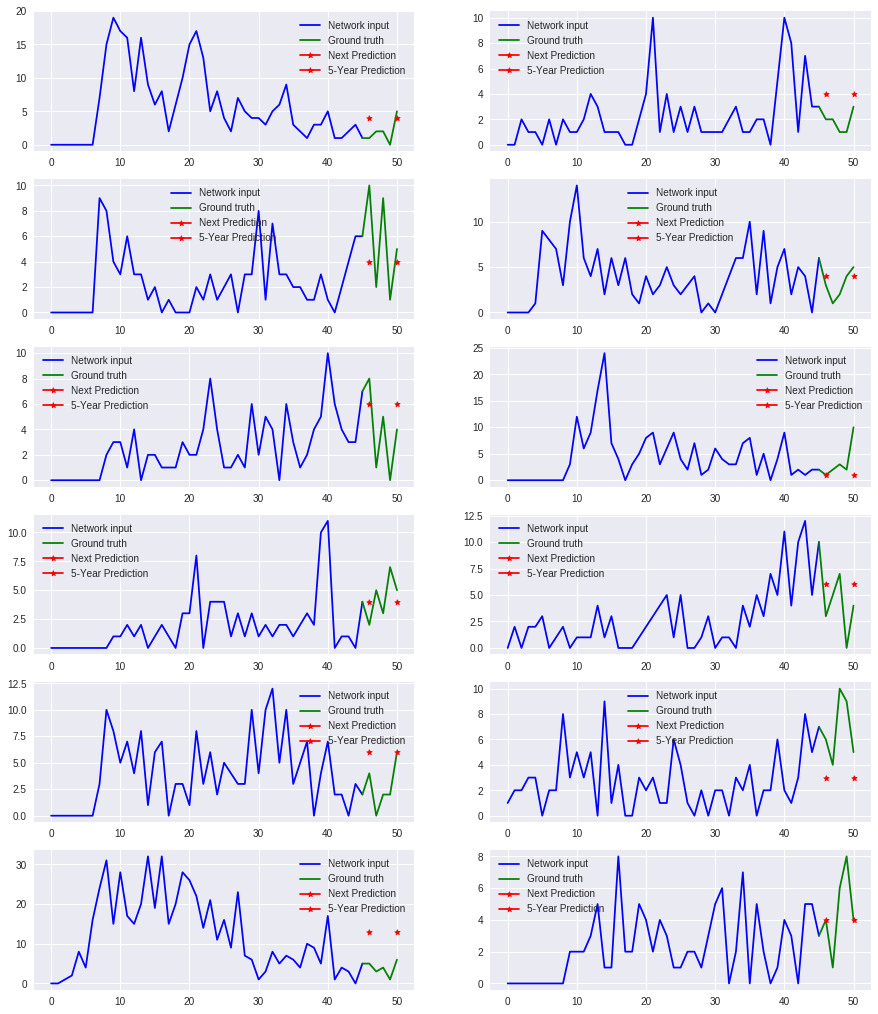

In [ ]:
#Plotting

numplots = test_dataset.shape[0]

fig, ax = plt.subplots(numplots//2,2,figsize=(15,1.5*numplots))
ax = ax.ravel()

predictions = df['Prediction']
predictions5 = df['Prediction-5']

for i,data in enumerate(zip(test_dataset,predictions,predictions5)):
  row = data[0]
  pred = data[1]
  pred5 = data[1]
  x=list(range(len(row)))

  ax[i].plot(x[:-5],row[:-5],color='b',label='Network input')
  ax[i].plot([x[-6],x[-5],x[-4],x[-3],x[-2],x[-1]],[row[-6],row[-5],row[-4],row[-3],row[-2],row[-1]],color='g', label = 'Ground truth')
  ax[i].plot(x[-5],pred,color='r',marker=(5, 1, 5),label='Next Prediction')
  ax[i].plot(x[-1],pred5,color='r',marker=(5, 1, 5),label='5-Year Prediction')
  ax[i].legend()